# classic GCN

In [8]:
import os
import networkx as nx
import torch
import numpy as np
import pandas as pd
import sys
sys.path.append("../codes")

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from torch_geometric.data import Data, DataLoader
from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_networkx
from sklearn.model_selection import KFold
from torch.utils.data.dataset import Subset

from model import GCN

In [9]:
def make_x(data):
    for num in range(len(data.y)):
        G = to_networkx(data[num])
        new_x = torch.tensor(
                [[i] for i in list(dict(nx.degree(G)).values())],
                dtype=torch.float,
            )
        if num == 0:
            x = new_x
        else:
            x = torch.cat([x, new_x])
    return x

In [10]:
# cv_train
def cv_train(loader, model):
    model.train()

    for data in loader:  # Iterate in batches over the training dataset.
        if data.x is None:
#             print("n")
            data.x = make_x(data)
        
        data.to(device)
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

# cv_valid
def cv_test(loader, model):
    model.eval()

    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        if data.x is None:
#             print("n")
            data.x = make_x(data)
        data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.

    val_acc = correct / len(loader.dataset)  # Derive ratio of correct predictions.
    return val_acc

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
fold = KFold(
    n_splits=10, shuffle=True, random_state=0
)

In [45]:
model = GCN(64, dataset=dataset)
model

GCN(
  (conv1): GCNConv(1, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=3, bias=True)
)

In [12]:
df = pd.DataFrame(columns=["name", "ave_acc", "std_acc"])
cnt = 0
for name in ["COLLAB", "MUTAG", "REDDIT-BINARY", "DD"]:
    print(name)
    dataset = TUDataset(root='data/TUDataset', name=name)
    torch.manual_seed(12345)
    dataset = dataset.shuffle()

    valid_accs = []
    for fold_idx, (train_idx, valid_idx) in enumerate(fold.split(dataset, dataset.data.y)):
        train_loader = DataLoader(
            dataset[[i for i in train_idx]],
            shuffle=True,
            batch_size=10,
        )
        valid_loader = DataLoader(
            dataset[[i for i in valid_idx]],
            shuffle=False,
            batch_size=10,
        )

        model = GCN(64, dataset=dataset)
        model.to(device)

        optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01)
        criterion = torch.nn.CrossEntropyLoss()

        for epoch_idx in range(10):

            cv_train(train_loader, model)
            valid_acc = cv_test(valid_loader, model)

        print(f"fold {fold_idx} : {valid_acc}")
        valid_accs.append(valid_acc)
    
    print("="*20)
    
    s = pd.Series([name, np.average(valid_accs), np.std(valid_accs)], index=df.columns,name=cnt)
    df = df.append(s)
    cnt += 1

COLLAB
fold 0 : 0.68
fold 1 : 0.664
fold 2 : 0.69
fold 3 : 0.68
fold 4 : 0.654
fold 5 : 0.66
fold 6 : 0.688
fold 7 : 0.67
fold 8 : 0.66
fold 9 : 0.638
MUTAG
fold 0 : 0.7368421052631579
fold 1 : 0.7368421052631579
fold 2 : 0.6842105263157895
fold 3 : 0.8947368421052632
fold 4 : 0.7368421052631579
fold 5 : 0.8947368421052632
fold 6 : 0.7894736842105263
fold 7 : 0.5789473684210527
fold 8 : 0.6666666666666666
fold 9 : 0.6111111111111112
REDDIT-BINARY
fold 0 : 0.675
fold 1 : 0.715
fold 2 : 0.745
fold 3 : 0.665
fold 4 : 0.725
fold 5 : 0.7
fold 6 : 0.695
fold 7 : 0.665
fold 8 : 0.61
fold 9 : 0.705
DD
fold 0 : 0.652542372881356
fold 1 : 0.6864406779661016
fold 2 : 0.7203389830508474
fold 3 : 0.7627118644067796
fold 4 : 0.711864406779661
fold 5 : 0.7457627118644068
fold 6 : 0.6779661016949152
fold 7 : 0.7542372881355932
fold 8 : 0.6923076923076923
fold 9 : 0.7008547008547008


In [13]:
df.to_csv("./paper_result/GCN_cv_degree.csv")

# DGCNN

In [14]:
import os
import networkx as nx
import torch
import numpy as np
import pandas as pd
import sys
sys.path.append("../codes")

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from torch_geometric.data import Data, DataLoader
from torch_geometric.datasets import TUDataset
from sklearn.model_selection import KFold
from torch.utils.data.dataset import Subset

from DGCNN import DGCNN_Model

In [15]:
# cv_train
def cv_train(loader, model, optimizer, criterion):
    model.train()

    for data in loader:  # Iterate in batches over the training dataset.
        if data.x is None:
            data.x = make_x(data)
        data.to(device)
        out = model(data)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

# cv_valid
def cv_test(loader, model,optimizer, criterion):
    model.eval()

    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        if data.x is None:
            data.x = make_x(data)
        data.to(device)
        out = model(data)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.

    val_acc = correct / len(loader.dataset)  # Derive ratio of correct predictions.
    return val_acc

In [16]:
df = pd.DataFrame(columns=["name", "ave_acc", "std_acc"])
cnt = 0
for name in ["MUTAG", "REDDIT-BINARY", "DD", "COLLAB"]:
    print(name)
    dataset = TUDataset(root='data/TUDataset', name=name)
    torch.manual_seed(12345)
    dataset = dataset.shuffle()

    valid_accs = []
    for fold_idx, (train_idx, valid_idx) in enumerate(fold.split(dataset, dataset.data.y)):
        train_loader = DataLoader(
            dataset[[i for i in train_idx]],
            shuffle=True,
            batch_size=10,
        )
        valid_loader = DataLoader(
            dataset[[i for i in valid_idx]],
            shuffle=False,
            batch_size=10,
        )
        if dataset.num_node_features == 0:
            node_feature = 1
        else:
            node_feature = dataset.num_node_features
        model = DGCNN_Model(node_feature, dataset.num_classes)
        model.to(device)

        optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01)
        criterion = torch.nn.CrossEntropyLoss()

        for epoch_idx in range(10):

            cv_train(train_loader, model, optimizer, criterion)
            valid_acc = cv_test(valid_loader, model, optimizer, criterion)

        print(f"fold {fold_idx} : {valid_acc}")
        valid_accs.append(valid_acc)
    
    print("="*20)
    
    s = pd.Series([name, np.average(valid_accs), np.std(valid_accs)], index=df.columns,name=cnt)
    df = df.append(s)
    cnt += 1



MUTAG
fold 0 : 0.8421052631578947
fold 1 : 0.8421052631578947
fold 2 : 0.8947368421052632
fold 3 : 0.9473684210526315
fold 4 : 0.8947368421052632
fold 5 : 0.7894736842105263
fold 6 : 0.7894736842105263
fold 7 : 0.7894736842105263
fold 8 : 0.8333333333333334
fold 9 : 0.7222222222222222
REDDIT-BINARY
fold 0 : 0.73
fold 1 : 0.735
fold 2 : 0.79
fold 3 : 0.76
fold 4 : 0.775
fold 5 : 0.825
fold 6 : 0.82
fold 7 : 0.705
fold 8 : 0.8
fold 9 : 0.75
DD
fold 0 : 0.7372881355932204
fold 1 : 0.7711864406779662
fold 2 : 0.711864406779661
fold 3 : 0.7796610169491526
fold 4 : 0.7627118644067796
fold 5 : 0.8050847457627118
fold 6 : 0.7033898305084746
fold 7 : 0.7542372881355932
fold 8 : 0.7863247863247863
fold 9 : 0.7435897435897436
COLLAB
fold 0 : 0.712
fold 1 : 0.704
fold 2 : 0.722
fold 3 : 0.702
fold 4 : 0.66
fold 5 : 0.644
fold 6 : 0.696
fold 7 : 0.648
fold 8 : 0.662
fold 9 : 0.632


In [17]:
df.to_csv("./paper_result/DGCNN_cv_degree.csv")

MUTAG
num dataset : 188
num class : 2
max nodes : 28
average nodes : 17.930851063829788
std nodes : 4.575664737098715
REDDIT-BINARY
num dataset : 2000
num class : 2
max nodes : 3782
average nodes : 429.627
std nodes : 554.0582305777978
DD
num dataset : 1178
num class : 2
max nodes : 5748
average nodes : 284.3166383701188
std nodes : 271.99968930043167
COLLAB
num dataset : 5000
num class : 3
max nodes : 492
average nodes : 74.4948
std nodes : 62.30084086880369


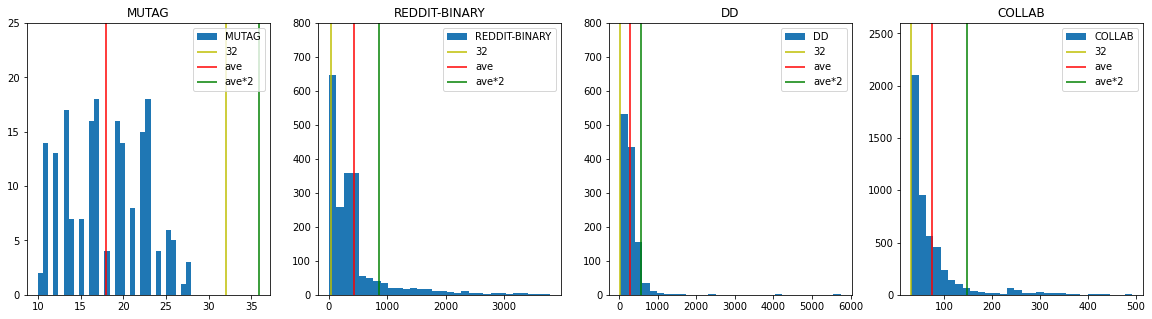

In [62]:
import matplotlib.pyplot as plt
from collections import Counter

%matplotlib inline

fig, axes = plt.subplots(1,4, figsize=(20,5))

y_max = [30, 900,900, 3000]
set_y_max = [25, 800, 800, 2600]

ax = axes.ravel()
for i, name in enumerate(["MUTAG", "REDDIT-BINARY", "DD", "COLLAB"]):
    print(name)
    dataset = TUDataset(root='data/TUDataset', name=name)
    torch.manual_seed(12345)
    print("num dataset : " + str(len(dataset)))
    print("num class : " + str(dataset.num_classes))
    nodes = [d.num_nodes for d in dataset]
    print("max nodes : " + str(max(nodes)))
    print("average nodes : " + str(np.average(nodes)))
    print("std nodes : " + str(np.std(nodes)))
    ax[i].hist(nodes, bins=30, label=name)
    
    ax[i].vlines(32, 0, y_max[i], color="y", label="32")
    ax[i].vlines(np.average(nodes), 0, y_max[i], color="r", label="ave")
    ax[i].vlines(np.average(nodes)*2, 0, y_max[i], color="g", label="ave*2")
    
    ax[i].set_ylim(0, set_y_max[i])
    
    ax[i].set_title(name)
    ax[i].legend()
    print("="*20)

plt.savefig("benchmark_nodes_hist.png", dpi=200)

In [18]:
from torch_geometric.nn import global_mean_pool

In [43]:
global_mean_pool(torch.tensor([[i for i in range(20)] for _ in range(10)]), torch.tensor([4 for i in range(10)]))

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19]])

In [30]:
for data in train_loader:
    d = data
    break

In [32]:
data.batch

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

In [44]:
model

DGCNN_Model(
  (conv1): GCNConv(1, 32)
  (conv2): GCNConv(32, 32)
  (conv3): GCNConv(32, 32)
  (conv4): GCNConv(32, 1)
  (conv5): Conv1d(1, 16, kernel_size=(97,), stride=(97,))
  (conv6): Conv1d(16, 32, kernel_size=(5,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier_1): Linear(in_features=352, out_features=128, bias=True)
  (drop_out): Dropout(p=0.5, inplace=False)
  (classifier_2): Linear(in_features=128, out_features=3, bias=True)
  (relu): ReLU(inplace=True)
)